In [1]:
import os
import numpy as np
from matplotlib import pyplot

# 1. Define the Activation function:

In [2]:
def activation(z, a_type, derivative=False):
    
    '''
    This function takes care of calculating the activations during forward propagation
    and derivative of activation in the backprop.
    
    Arguments: 
    --------------------
    Z          : The preactivations
    a_type     : Name of the activation function as a string
    derivative : True during backprop, False to just calculate activations
    
    Valid a_types:
        * 'sigmoid'
        * 'tanh'
        * 'relu'
        * 'leakyrelu'
    
    Returns:
    --------------------
    Activation if derivative = False
    dericative if derivative = True
    '''
    

    if a_type == 'sigmoid':
        if derivative:
            s = activation(z, a_type='sigmoid')
            return s*(1-s)
            # return the derivative of the sigmoid activation function
        else:
            return 1/(1+np.exp(-z))
            # return the normal sigmoid activation function
    
    if a_type == 'tanh':
        if derivative:
            a = activation(z, a_type='tanh')
            return (1-a**2)
        else:
            return np.tanh(z)
    
    if a_type == 'relu':
        if derivative:
            return (z > 0) * 1
        else:
            # fastest way to calculate relu:
            return (abs(z) + z) / 2
    
    if a_type == 'leakyrelu':
        if derivative:
            return ((z > 0)*1 + (z<=0)*0.2)
        else:
            return ((z > 0)*z + (z<=0)*0.2*z)
    
    else:
        return -1

def accuracy(arr1, arr2):
    '''
    This function calculates how accurate arr2 is to arr1 (fraction of perfect matches)
    
    Arguments:
    ---------------------
    arr1: Numpy array1
    arr2: Numpy array2
    
    Returns:
    ---------------------
    accuracy as described above!
    '''
    
    return(np.sum(arr1==arr2)/len(arr1))

# 2. Define the loss function and a function to find derivative of loss:

In [3]:
def cross_entropy_loss(y_true, y_pred, epsilon=0.0000002):
    '''
    This function returns the element wise cross entropy ( log loss )
    
    For arrays of size (n, 1), it returns an array of (n, 1)
    
    To get a single number for loss across all examples do a np.mean() for the output of this function
    
    Arguments:
    -------------------
    y_true: The ground truth values (as 0 or 1) wrt which loss has to be found
    y_pred: The predictions for which the loss has to be found
    
    Returns: 
    -------------------
    Element wise log loss
    '''
    
    # clip the y_pred to avoid infinite loss 
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    
    # reshape np array for simpler calculation
    shape = y_true.shape
    size = np.prod(shape)
    y_true = np.reshape(y_true, (size,))
    y_pred = np.reshape(y_pred, (size,))
    
    # calculate cost using masks
    cost = np.zeros(shape)
    cost = (y_true==0)*( -1*np.log(1-y_pred) ) + (y_true==1)*( -1*np.log(y_pred) )
    return cost

def cross_entropy_prime(y_true, y_pred, epsilon=0.0000002):
    '''
    This function is used to find the derivative of the cross_entropy_loss function
    
    For arrays of size (n, 1), it returns an array of (n, 1)
    
    Arguments:
    -------------------
    y_true: The ground truth values (as 0 or 1) wrt which loss has to be found
    y_pred: The predictions for which the loss has to be found
    
    Returns: 
    -------------------
    derivatives wrt y_true and y_pred 
    '''
    
    # clip the y_pred to avoid infinite loss 
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    
    # save the dimentions:
    shape = y_true.shape
    size = np.prod(shape)
    
    # reshape for simpler calculations:
    y_true = np.reshape(y_true, (size,))
    y_pred = np.reshape(y_pred, (size,))

    # Calculate the derivative of the cost function
    cost_prime = np.zeros(y_pred.shape)
    cost_prime[y_true==0] = 1/(1-y_pred[y_true==0])
    cost_prime[y_true==1] = -1/y_pred[y_true==1]
    
    return cost_prime.reshape(shape)

# Write the nn:

In [4]:
class NeuralNetwork(object):
    
    '''
    This class contains all the functions of the neural network.
    Initialize a classic Neural Network by calling the constructor of this class!
    '''
    
    def __init__(self, size, activation = 'relu', out_activation='sigmoid'):
        '''
        The constructor of this class!
        Use this constructor to define the hyperparameters of the nn you want to design!
        
        Arguments:
        ----------------------
        size: The shape of a nn. For example a nn with 7 input nodes, then a hidden layer with 5 nodes and a 1 node output
              will have the 'size' parameter as: [7, 5, 1]
        
        activation     : the activations of all the hidden layers as a string
        out_activation : the activation of the output layer as a string
        
        valid activation/ outactivation values:
            * 'sigmoid'
            * 'tanh'
            * 'relu'
            * 'leakyrelu'
            
        Returns: 
        ----------------------
        A neural network object
        '''
        print('[INFO] initializing network')
        self.size = size
        self.activation = activation
        self.out_activation = out_activation
        
        # initialzie biases and variance
        self.biases = [np.zeros((n, 1)) for n in self.size[1:]]
        # use he initialization
        self.weights =[np.random.randn(a, b)*np.sqrt(2/(a+b)) for a,b in zip(size[1:], size[:-1])]
     
    
    def forward(self, inpt):
        '''
        Used in the forward propagation
        [NOTE] to calculate just the outputs use calc_output
        
        Argument:
        -----------------
        inpt: inputs for the nn *** with number of examples as the second dimention *** 
        
        output:
        out_activations, all pre-activations of nn, all acttivations of nn'''
        
        # do one forward prop
        a = inpt
        pre_activations = []
        activations = [a]
        
        # all the hidden layers
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = np.dot(w, a) + b
            a  = activation(z, a_type=self.activation)
            pre_activations.append(z)
            activations.append(a)
            
        # out layer:
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a  = activation(z, a_type=self.out_activation)
        pre_activations.append(z)
        activations.append(a)
        
        return a, pre_activations, activations    
    
    
    def calc_output(self, inpt):
        '''
        Same as the forward function but 
        doesn't return pre_activations or activations
        
        Argument:
        -----------------
        inpt: inputs for the nn *** with number of examples as the second dimention **
        
        Output:
        -----------------
        output layer activations
        '''
        
        a = inpt
        
        # all the hidden layers
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = np.dot(w, a) + b
            a = activation(z, a_type=self.activation)
            
        # last layer without activation
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a = activation(z, a_type=self.out_activation)
        
        return a
    
    
    def compute_deltas(self, pre_activations, y_true = None, y_pred=None, dis_cache=None):
        '''
        Compute the deltas of all the nodes used to calculate the derivatives of all the weights and biases
        
        Working 1:
        [use this if this is the topmost nn]
        
        Arguments:
        ----------------
        pre_activations : pre activations (z) outputed by forward() function
        y_true          : The ground truth y values
        y_pred          : The outputs calculated by this neural network object
        dis_cache       : Leave as None
        
        Working 2:
        [use this if this is not the topmost nn and outputs of this nn is consumed by another nn ]
        [ so now you have to backpropagate from that top nn into this one ]
        
        Arguments:
        ----------------
        pre_activations : pre activations (z) outputed by forward() function
        y_true          : Leave as None
        y_pred          : Leave as None
        dis_cache       : a dicionary with keys:
                          'weights0': the weights of the input layer of nn just on top of this one
                          'deltas0' : the deltas of the input layer of the nn just on top of this one, 
                                      used to backpropagate into this nn
        returns: 
        ----------------
        deltas of all nodes this nn, dis_cache you can use to backprop into any nn whose outputs this one gets as inputs.
        
        '''
        # initialize array to store the derivatives
        deltas = [0] * (len(self.size) - 1)


        # Calculate the delta for each layer
        # This is the first step in calculating the derivative
        # The last layer is calculated as derivative of cost function *  derivative of sigmoid ( pre-activations of last layer )
        if dis_cache is None:
            deltas[-1] = cross_entropy_prime(y_true, y_pred) * activation(pre_activations[-1], a_type= self.out_activation, derivative=True) 
        
        # If this nn has to backpropagate from some other nn on top of this one:
        else:
            deltas[-1] = np.dot(dis_cache['weights0'].T, dis_cache['deltas0']) * activation(pre_activations[-1], a_type= self.out_activation, derivative=True)
        

        # Recursively calculate delta for each layer from the previous layer
        for l in range(len(deltas) - 2, -1, -1):
            # deltas of layer l depend on the weights of layer l and l+1 and on the sigmoid derivative of the pre-activations of layer l            # Note that we use a dot product when multipying the weights and the deltas
            # Check their shapes to ensure that their shapes conform to the requiremnts (You may need to transpose some of the matrices)
            # The final shape of deltas of layer l must be the same as that of the activations of layer l
            # Check if this is true
            deltas[l] = np.dot(self.weights[l+1].T,deltas[l+1]) * activation(pre_activations[l], a_type=self.activation, derivative=True)
        
        # make the cache
        cache = {
            'weights0': self.weights[0],
            'deltas0': deltas[0]
        }
        
        return deltas, cache
    
    
    def backpropagate(self, deltas, pre_activations, activations):
    
        '''
        This function is used to calculate the derivatives of all the weights and biases from the deltas
        
        
        Arguments:
        --------------------
        deltas          : The deltas of each node calculated by compute_deltas
        pre_activations : The pre-activations (z) calculated in the forward propagation
        activations     : The activations (a) calculated in the forward propagation
        
        returns:
        --------------------
        The derivatives of all the weights and biases
        '''
        
        # initialize the derivatives:
        dW = []
        db = []
        deltas = [0] + deltas
        
        # go through all the layers!
        for l in range(1, len(self.size)):
            dW_temp = np.dot(deltas[l], activations[l-1].T)
            db_temp = deltas[l]
            dW.append(dW_temp)
            db.append(np.expand_dims(db_temp.mean(axis=1), 1))
        
        
        return dW, db
    
    
    def train(self, X, y=None, learning_rate=0.01, dis_cache=None, should_print = True, print_acc=True, learn=True):        
        
        '''
        Use this function to train the nn!!!
        
        
        Working 1:
        [use this if this is the topmost nn]
        
        Arguments:
        -------------------
        [NOTE]: The data is accepted with number of examples as index 2, not the first index like in tensorflow!!
        
        X             : The input of the training data
        y             : The output of the training data
        dis_cache     : Leave as None
        learning_rate : The learning rate for the gradient desent
        should_print  : True if you want this nn to print it's performance wrt to y_true, else pass False
        print_acc     : If True it prints the accuracy while printing the performance
        learn         : True if you want this nn to learn from the training data, else False
        
        
        Working 2:
        [use this if this is not the topmost nn and outputs of this nn is consumed by another nn ]
        [ so now you have to backpropagate from that top nn into this one ]
        
        Arguments:
        -------------------
        [NOTE]: The data is accepted with number of examples as index 2, not the first index like in tensorflow!!
        
        X             : The input of the training data
        y             : leave as None
        dis_cache     : the cache from training of the nn, just on top of this one (used for backpropagation)
        learning_rate : The learning rate for the gradient desent
        should_print  : True if you want this nn to print it's performance wrt to y_true, else pass False
        print_acc     : If True it prints the accuracy while printing the performance
        learn         : True if you want this nn to learn from the training data, else False
        
        
        returns:
        -------------------
        history (dictionary containing the training loss and training accuacy *** before training ***), 
        cache from compute deltas
        '''
        
        # rename the variables for more readable code!
        x_train = X
        y_train = y
        
        
        '''
        calculate the mertics and show how good the preformance is before training:
        '''
        
        history = None
        if y is not None:
            # calculate metrics on training data
            y_train_pred = self.calc_output(x_train)
            train_loss = cross_entropy_loss(y_train, y_train_pred)
            train_accuracy = accuracy(np.argmax(y_train, axis=0), np.argmax(y_train_pred, axis=0))
            
            history = {'train_loss': train_loss,
                       'train_acc': train_accuracy,
                       }
            
            # print
            if should_print:
                if print_acc:
                    print('[INFO] train loss: {} | train accuracy: {}'.format(
                            '%0.3f'%np.mean(train_loss), '%0.3f'%train_accuracy))
                else:
                    print('[INFO] train loss: {} '.format('%0.3f'%np.mean(train_loss)))
                    
        
        
        '''
        Train the model!!::
        '''               
        y_pred, pre_activations, activations = self.forward(x_train)
        if dis_cache is not None:
            # if you backprop from another nn on top. Follow this:
            deltas, cache = self.compute_deltas(pre_activations, dis_cache=dis_cache )
        else:
            # If this is the topmost nn:
            deltas, cache = self.compute_deltas(pre_activations, y_true=y_train, y_pred=y_pred)
        dW, db = self.backpropagate(deltas, pre_activations, activations)
        
        
        # update time!!!!
        if learn: 
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate*dW[i]
                self.biases[i] -= learning_rate*db[i]
                
        return history, cache
    
    

# Check if nn works:

To do this, we will use the NeuralNetwork class to make a classifier that classifies these 28x28 MNIST images into it's categories (0 to 9).
<br>
<br>
<img src="readme_images/MnistExamples.png">

In [5]:
# load the data
X_train        = np.load('data/train_images.npy')
y_train_labels = np.load('data/train_labels.npy')
X_test         = np.load('data/test_images.npy')
y_test_labels  = np.load('data/test_labels.npy')

# convert to onehot vector
y_train = np.eye(10)[y_train_labels.astype(int).flatten()]
y_test = np.eye(10)[y_test_labels.astype(int).flatten()]

# normalize
# mean = np.mean(X_train)
# std = np.std(X_train)
# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# [or]

# Scale
X_train = X_train/255

'''
Here we choose scaling instead of normalization because,
We will be using this same dataset for the gan!
If we normalize the data, we will have inputs in a unbounded range,
but if we only scale, we know the outputs will be [0, 1] and,
we can achieve pixels of this range as outputs with a sigmoid out activation easily.'''

# understand the shape of the dataset
print('Shapes:')
print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test :', X_test.shape)
print('y test :', y_test.shape)

Shapes:
X train: (60000, 784)
y train: (60000, 10)
X test : (10000, 784)
y test : (10000, 10)


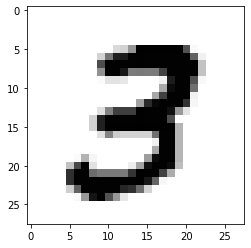

y:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [6]:
# look through the x and y of the dataset!
EXAMPLE_NO = 7

pyplot.imshow(X_train[EXAMPLE_NO].reshape(28, 28), cmap='gray_r')
pyplot.show()
print('y: ', y_train[EXAMPLE_NO])

In [7]:
# initialize the neural network!
nn = NeuralNetwork([784, 10], activation = 'relu', out_activation='sigmoid')
print('[INFO] Done!!')

'''
Notice how small this nn is! Zero hidden layers and still it works with > 90% accuracy!!
(if you want more accuracy add some hidden layers, but we are not solving classification now, 
we just want to see if this nn class works)
'''
print()

[INFO] initializing network
[INFO] Done!!



In [8]:
# define the batch size and number of epochs
BATCH_SIZE = 128
N_EPOCHS = 7

# iterate through n epochs
for e in range(N_EPOCHS):
    for b in range(int(60000/BATCH_SIZE)):
        
        # calculate when to show the metrics to the user!
        if b == 0:
            out = True
        else:
            out = False
        
        # slice out the batch
        X_train_batch = X_train[b*BATCH_SIZE: b*BATCH_SIZE+BATCH_SIZE].T
        y_train_batch = y_train[b*BATCH_SIZE: b*BATCH_SIZE+BATCH_SIZE].T
        
        # Training Time!!!!!!
        nn.train( X_train_batch, y_train_batch, learning_rate=0.001, should_print = out)
        
        # calculate the accuracy on the test set:
        if out:
            y_test_pred = nn.calc_output(X_test.T)
            test_loss = cross_entropy_loss(y_test, y_test_pred)
            test_accuracy = accuracy(np.argmax(y_test.T, axis=0), np.argmax(y_test_pred, axis=0))
            print('[INFO] test  loss: {} | test  accuracy: {}'.format(
                        '%0.3f'%np.mean(test_loss), '%0.3f'%test_accuracy))
print()
print('Done!!!')

[INFO] train loss: 0.700 | train accuracy: 0.047
[INFO] test  loss: 1.545 | test  accuracy: 0.148


c:\users\pmicc laptop\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


[INFO] train loss: 0.079 | train accuracy: 0.938
[INFO] test  loss: 2.620 | test  accuracy: 0.885
[INFO] train loss: 0.071 | train accuracy: 0.945
[INFO] test  loss: 2.657 | test  accuracy: 0.895
[INFO] train loss: 0.067 | train accuracy: 0.945
[INFO] test  loss: 2.669 | test  accuracy: 0.898
[INFO] train loss: 0.065 | train accuracy: 0.938
[INFO] test  loss: 2.676 | test  accuracy: 0.901
[INFO] train loss: 0.064 | train accuracy: 0.938
[INFO] test  loss: 2.682 | test  accuracy: 0.903
[INFO] train loss: 0.063 | train accuracy: 0.938
[INFO] test  loss: 2.686 | test  accuracy: 0.904

Done!!!


<br><br><br>
# Stacked NN
Before training a gan, Let's understand how to train two neural networks that are stacked on top of each other. We'll do it on the same MNIST dataset to avoid any confusions.

To do this let's train a stacked nn where one nn (nn2) that gives us the final output (the class of the image), gets it's input from the output of another nn (nn1)! This nn, (nn1) is the one that takes the actual input ( the pixel values )!

This will help us understand how we can backpropagate from one nn through a second one!

NOTE: for the out activation of nn1 use only sigmoid or tanh, Don't use relu or leakyrelu

In [9]:
nn1 = NeuralNetwork([784, 256, 64], activation = 'leakyrelu', out_activation='tanh')
nn2 = NeuralNetwork([64, 16, 10], activation = 'leakyrelu', out_activation='sigmoid')
print('[INFO] Done!!')

# just to show how good this works we took a relatively deep nn ( if we see nn1 and nn2 combined)
# but even this works really good with both nn1 and nn2 not having even 1 hidden layer!

[INFO] initializing network
[INFO] initializing network
[INFO] Done!!


In [10]:
BATCH_SIZE = 128

for e in range(5):
    for b in range(int(60000/BATCH_SIZE)):
        if b == 0:
            out = True
        else:
            out = False
        
        X_train_nn1   = X_train[b*BATCH_SIZE: b*BATCH_SIZE+BATCH_SIZE].T
        X_train_nn2   = nn1.calc_output(X_train_nn1)
        y_train_batch = y_train[b*BATCH_SIZE: b*BATCH_SIZE+BATCH_SIZE].T
        
        
        # train nn2
        _, cache = nn2.train(X_train_nn2, y_train_batch, learning_rate=0.001, should_print = out)
        # backprop into nn1
        nn1.train( X_train_nn1, dis_cache=cache, learning_rate=0.001, should_print = out)
        
        if out:
            nn1_out = nn1.calc_output(X_test.T)
            y_test_pred = nn2.calc_output(nn1_out)
            test_loss = cross_entropy_loss(y_test, y_test_pred)
            test_accuracy = accuracy(np.argmax(y_test.T, axis=0), np.argmax(y_test_pred, axis=0))
            print('[INFO] test  loss: {} | test  accuracy: {}'.format(
                        '%0.3f'%np.mean(test_loss), '%0.3f'%test_accuracy))

print()
print('Done!!!')

[INFO] train loss: 0.676 | train accuracy: 0.102
[INFO] test  loss: 0.537 | test  accuracy: 0.141
[INFO] train loss: 0.031 | train accuracy: 0.961
[INFO] test  loss: 1.287 | test  accuracy: 0.931
[INFO] train loss: 0.020 | train accuracy: 0.977
[INFO] test  loss: 1.470 | test  accuracy: 0.952
[INFO] train loss: 0.018 | train accuracy: 0.977
[INFO] test  loss: 1.582 | test  accuracy: 0.961
[INFO] train loss: 0.016 | train accuracy: 0.977
[INFO] test  loss: 1.674 | test  accuracy: 0.965

Done!!!


<br><br><br>
# The Gan!!!! 
Atlast! yaay!!!!

### The structure of a GAN:

<img src ='readme_images/gan.png'>

In [11]:
# helper functions:

def generate_latent_points(latent_dim, n_samples):
    ''' 
    This function generates random latent feature vectors from a normal distribution
    
    Arguments:
    -----------------
    latent_dim : the number of latent features needed for generation of one image
    n_samples  : the number or latent vectors needed
    
    Returns:
    -----------------
    n_samples amount of latent vectors
    '''
    
    # generate points in the latent space
    return np.random.randn(latent_dim, n_samples) 

def generate_and_save_images(e):
    
    '''
    use the generator to generate and store its results!!
    
    Arguments:
    e: name of the image to be saved ( can be a string or epoch number)
    '''
    
    
    # generate 50 images
    latent_features = np.random.randn(N_LATENT_FEATURES, 50)
    generated_images = generator.calc_output(latent_features)

    for i in range(50):
        # define subplot
        pyplot.subplot(5, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(generated_images[:, i].reshape(28, 28), cmap='gray_r')
        
    # save plot to file
    cwd = os.getcwd()
    if type(e) == str:
        filename = os.path.join(cwd, 'outputs','1',e+'.png')
    else:
        filename = os.path.join(cwd, 'outputs','1',str(e)+'.png')
    pyplot.savefig(filename)
    pyplot.close()

In [16]:
# Note we can also interpret the 'noise' vector as a latent feature space!

# define the nn structure
N_LATENT_FEATURES = 10
N_IMAGE = 784

# initialize the two neural networks:
discriminator = NeuralNetwork([N_IMAGE, 32, 8, 1],                 activation = 'leakyrelu', out_activation='sigmoid')
generator     = NeuralNetwork([N_LATENT_FEATURES, 64, N_IMAGE], activation = 'leakyrelu', out_activation='sigmoid')

print('[INFO] Done!!')

[INFO] initializing network
[INFO] initializing network
[INFO] Done!!


In [17]:
# Now train the GAN!!!

BATCH_SIZE  = 128
HALF_BATCH = int(BATCH_SIZE/2)

# initialize stuff:
discriminator_loss = 0.6

# generate images from the untrained model:
generate_and_save_images('initial')

for e in range(25):
    for b in range(int(60000/HALF_BATCH)):
        
        # decide when to print:
        if b == 0:
            out = True
        else:
            out = False            
        
        
        # decide how to learn:
        '''
        If discriminator is too strong train only the generator, and vice versa.
        On the other hand if none of them overpowers the other, train both!'''
        if discriminator_loss > 0.8:
            # generator has grown too powerful!!!
            d_learn = True
            g_learn = False
            
        elif discriminator_loss < 0.3:
            # discriminator has grown too powerful!!!
            d_learn = False
            g_learn = True
            
        else:
            # they are well balanced :)
            d_learn = True
            g_learn = True
            
            
        '''
        Train the discriminator
        '''
        # real data:
        X_train_real = X_train[b*HALF_BATCH: b*HALF_BATCH+HALF_BATCH].T
        y_train_real = np.ones((1, HALF_BATCH))

        # fake data:
        latent_features = generate_latent_points(N_LATENT_FEATURES, HALF_BATCH)
        X_train_generated = generator.calc_output(latent_features)
        y_train_generated = np.zeros((1, HALF_BATCH))

        # complete training set for discriminator:
        X_train_batch = np.append(X_train_generated, X_train_real, axis=1)
        y_train_batch = np.append(y_train_generated, y_train_real, axis=1)

        # train the discriminator:
        history, _ = discriminator.train(X_train_batch, y_train_batch, learning_rate=0.001, should_print = out, print_acc=False, learn=d_learn)

        discriminator_loss = np.mean(history['train_loss'])
        
        
        '''
        Train the generator
        '''
        # create latent features and y:
        latent_features         = generate_latent_points(N_LATENT_FEATURES, BATCH_SIZE)
        X_train_generated_batch = generator.calc_output(latent_features)
        y_train_batch           = np.ones((1, BATCH_SIZE)) 
        
            # the discriminator is trained to say 1 to real data and zero to fake ones.
            # but to this we pass all ones even though we pass fake images because we
            # want the generator to learn to make the discriminator say this false prediction!
        
        # forward and backprop on discriminator:
        # Note: Donot learn here!
        _, cache = discriminator.train(X_train_generated_batch, y_train_batch, learning_rate=0.001, should_print = False, learn=False)
        # backprop into generator
        generator.train( latent_features, dis_cache=cache, learning_rate=0.001, should_print = False, learn=g_learn)
        
        if out:
            generate_and_save_images(e)

generate_and_save_images('final')
print('Done!!!')

[INFO] train loss: 0.883 
[INFO] train loss: 0.372 
[INFO] train loss: 0.363 
[INFO] train loss: 0.347 
[INFO] train loss: 0.355 
[INFO] train loss: 0.395 
[INFO] train loss: 0.340 
[INFO] train loss: 0.399 
[INFO] train loss: 0.446 
[INFO] train loss: 0.493 
[INFO] train loss: 0.507 
[INFO] train loss: 0.405 
[INFO] train loss: 0.433 
[INFO] train loss: 0.453 
[INFO] train loss: 0.379 
[INFO] train loss: 0.462 
[INFO] train loss: 0.408 
[INFO] train loss: 0.346 
[INFO] train loss: 0.420 
[INFO] train loss: 0.443 
[INFO] train loss: 0.465 
[INFO] train loss: 0.438 
[INFO] train loss: 0.477 
[INFO] train loss: 0.434 
[INFO] train loss: 0.427 
Done!!!


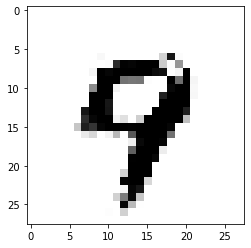

In [22]:
# lets generate some examples:
latent_features = np.random.randn(N_LATENT_FEATURES, 1)
generated_image = generator.calc_output(latent_features)

pyplot.imshow(generated_image.reshape(28, 28), cmap='gray_r')
pyplot.show()

yaay!!

# Results:

The gan has been trained! But it was trained only on a cpu (since we used only numpy package and did not do any cuda coding ) and we trained it only for 25 epochs (~ 30 mins in a laptop 4 core i5 cpu ). We can improve the performance by, making the network bigger, training it for longer etc. But if we want to improve our model a lot, what we can do is use a CNN instead of a vanilla RNN!

### epoch 0:
<img src = 'outputs/1/initial.png'>

### epoch 5:
<img src = 'outputs/1/5.png'>

### final random samples:
<img src = 'outputs/1/final.png'>

## Good examples underlined:

<img src = 'readme_images/results.png'>

<img src = 'readme_images/the_end.jpg'>